
# Portfolio Analysis Demo (QuantStats + PyPortfolioOpt)

This notebook is a minimal, offline-ready demo that shows how to:
- Generate synthetic price data for a few tickers
- Compute returns and basic risk metrics
- Create a quick performance summary with **QuantStats**
- Optimize weights with **PyPortfolioOpt** (mean-variance example)
- Plot equity curve and risk contributions

> Run this inside your `invest` conda environment:
>
> ```bash
> conda activate invest
> jupyter lab
> ```


In [1]:

# Versions and imports
import sys, platform
print('Python:', sys.version.split()[0], '| Platform:', platform.platform())

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# QuantStats and PyPortfolioOpt
import quantstats as qs
from pypfopt import expected_returns, risk_models, EfficientFrontier, objective_functions

# Make plots inline if in Jupyter
%matplotlib inline


Python: 3.11.13 | Platform: macOS-15.6.1-arm64-arm-64bit


Matplotlib is building the font cache; this may take a moment.



## 1. Generate synthetic price data
We simulate daily prices for 4 tickers over ~2 years of business days. This avoids any external data dependency.


In [2]:

import numpy as np, pandas as pd
np.random.seed(42)
dates = pd.date_range('2023-01-03', periods=252*2, freq='B')
tickers = ['VTI','VXUS','BND','BIL']

# annualized drifts and vols (illustrative only)
mu_ann = np.array([0.08, 0.07, 0.03, 0.02])
vol_ann = np.array([0.18, 0.20, 0.06, 0.01])

mu_d = mu_ann / 252.0
vol_d = vol_ann / np.sqrt(252.0)

prices = pd.DataFrame(index=dates, columns=tickers, dtype=float)
prices.iloc[0] = [200.0, 60.0, 75.0, 100.0]
for t in range(1, len(dates)):
    shock = np.random.normal(0, vol_d)
    prices.iloc[t] = prices.iloc[t-1] * (1 + mu_d + shock)

prices.head()


,VTI,VXUS,BND,BIL
2023-01-03,200.000000,60.000000,75.000000,100.000000
2023-01-04,201.189934,59.912149,75.192531,100.103878
2023-01-05,200.719634,59.752059,75.650296,100.160217
2023-01-06,199.714856,60.177099,75.526797,100.138781
2023-01-09,200.326194,58.743242,75.043385,100.111259



## 2. Compute returns and basic metrics
We will use log returns for aggregation and transform to arithmetic returns for some libraries.


In [3]:

logret = np.log(prices).diff().dropna()
ret = logret.apply(np.exp) - 1.0  # convert to simple returns
ret.describe()


,VTI,VXUS,BND,BIL
count,503.000000,503.000000,503.000000,503.000000
mean,0.000593,0.001113,0.000244,0.000108
std,0.010511,0.012706,0.003773,0.000642
min,-0.029742,-0.036212,-0.012132,-0.001773
25%,-0.006690,-0.007438,-0.002177,-0.000342
50%,0.000834,0.001201,0.000226,0.000098
75%,0.007520,0.009125,0.002627,0.000549
max,0.028970,0.048818,0.011756,0.002091



## 3. Quick performance summary with QuantStats
QuantStats can compute a variety of metrics and plots. We will build a simple **portfolio** using naive 60/20/18/2 weights and view the metrics.


In [4]:

import quantstats as qs
w = pd.Series({'VTI':0.60,'VXUS':0.20,'BND':0.18,'BIL':0.02})
w = w / w.sum()

# portfolio daily returns (weighted sum of component returns)
pf_ret = (ret * w).sum(axis=1)

# Basic stats table
qs.reports.metrics(pf_ret, display=True, mode='basic')


                     Strategy
-------------------  ----------
Start Period         2023-01-04
End Period           2024-12-06
Risk-Free Rate       0.0%
Time in Market       100.0%

Cumulative Return    35.36%
CAGR﹪               16.38%

Sharpe               1.47
Prob. Sharpe Ratio   98.15%
Sortino              2.28
Sortino/√2           1.61
Omega                1.26

Max Drawdown         -10.53%
Max DD Date          2023-09-25
Max DD Period Start  2023-06-08
Max DD Period End    2023-12-19
Longest DD Days      195

Gain/Pain Ratio      0.26
Gain/Pain (1M)       2.0

Payoff Ratio         1.08
Profit Factor        1.26
Common Sense Ratio   1.46
CPC Index            0.73
Tail Ratio           1.16
Outlier Win Ratio    2.79
Outlier Loss Ratio   2.7

MTD                  -0.33%
3M                   0.58%
6M                   9.2%
YTD                  21.92%
1Y                   30.16%
3Y (ann.)            16.38%
5Y (ann.)            16.38%
10Y (ann.)           16.38%
All-time (ann.)      16.


### Equity curve


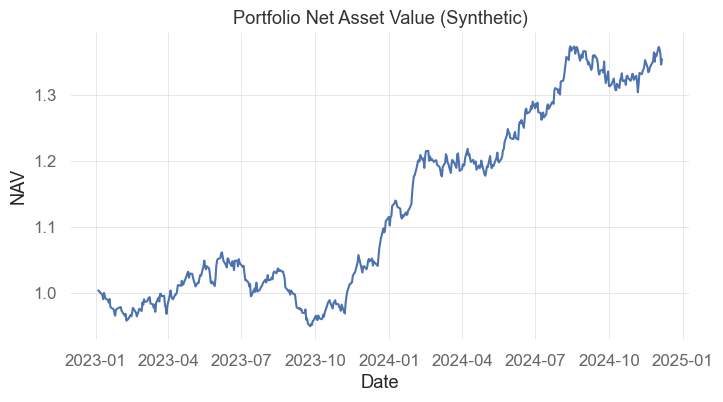

In [5]:

nav = (1 + pf_ret).cumprod()
plt.figure(figsize=(8,4))
plt.plot(nav.index, nav.values)
plt.title('Portfolio Net Asset Value (Synthetic)')
plt.xlabel('Date')
plt.ylabel('NAV')
plt.show()



## 4. Optimize weights with PyPortfolioOpt
We use mean-variance optimization with a target of maximizing the Sharpe ratio, along with an L2 regularization term to avoid extreme weights.


In [6]:

from pypfopt import expected_returns, risk_models, EfficientFrontier, objective_functions

mu = expected_returns.mean_historical_return(prices, frequency=252)  # expected annual return
S = risk_models.sample_cov(prices, frequency=252)                    # annualized covariance

ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=0.001)
opt_w = ef.max_sharpe(risk_free_rate=0.0)
clean_w = ef.clean_weights()
perf = ef.portfolio_performance(verbose=True, risk_free_rate=0.0)

clean_w


Expected annual return: 8.8%
Annual volatility: 3.7%
Sharpe Ratio: 2.37


/Users/harryzhang/miniforge3/envs/invest/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('VTI', 0.1064),
             ('VXUS', 0.14193),
             ('BND', 0.27966),
             ('BIL', 0.47201)])


### Risk contributions (from covariance and optimized weights)


In [7]:

import numpy as np, pandas as pd

def annualized_cov(returns: pd.DataFrame, periods_per_year=252) -> pd.DataFrame:
    return returns.cov() * periods_per_year

def portfolio_volatility(w: pd.Series, cov: pd.DataFrame) -> float:
    w = w.values if isinstance(w, pd.Series) else np.asarray(w)
    v = float(np.sqrt(max(w @ cov.values @ w, 0.0)))
    return v

def risk_contribution(w: pd.Series, cov: pd.DataFrame) -> pd.Series:
    wv = pd.Series(w, index=cov.index)
    total_vol = portfolio_volatility(wv, cov)
    mrc = cov @ wv  # marginal risk contribution
    rc = wv * mrc / total_vol
    return rc

cov_a = annualized_cov(ret)
opt_w_series = pd.Series(clean_w).reindex(cov_a.index).fillna(0.0)
rc = risk_contribution(opt_w_series, cov_a).sort_values(ascending=False)
rc.to_frame('RiskContribution')


,RiskContribution
VXUS,0.021560
VTI,0.007792
BND,0.006908
BIL,0.000787



## 5. Value-at-Risk (VaR) and Expected Shortfall (ES)
Historical method on portfolio daily returns.


In [8]:

def var_es_hist(ret_series: pd.Series, alpha=0.95):
    q = ret_series.quantile(1 - alpha)
    es = ret_series[ret_series <= q].mean()
    return {"VaR": float(q), "ES": float(es)}

# Use optimized weights to form portfolio returns
pf_ret_opt = (ret * opt_w_series.reindex(ret.columns).fillna(0.0)).sum(axis=1)
risk_95 = var_es_hist(pf_ret_opt, alpha=0.95)
risk_99 = var_es_hist(pf_ret_opt, alpha=0.99)
risk_95, risk_99


({'VaR': -0.0035010370153364424, 'ES': -0.004336836357091529},
 {'VaR': -0.004971343247503935, 'ES': -0.005346931195132361})


## 6. Wrap up
You now have:
- Synthetic prices and returns
- A quick QuantStats summary
- Mean-variance optimized weights from PyPortfolioOpt
- Risk contributions and VaR/ES estimates

Next steps you can try:
- Swap synthetic data for your real data source
- Add transaction costs and turnover constraints in the optimizer
- Run scenario replays and drawdown analyses for stress testing
